# *Deep Reinforced Learning*

Hoy en día el estado del arte en el reconocimiento de patrones está dominado por las **redes neuronales profundas**

- Visión Computacional: Redes Neuronales Convolucionales, Adversarios generativos
- Reconocimiento de habla: Redes Recurrentes, WaveNet
- Procesamiento de lenguaje Natural: Transformers

Las redes neuronales son excelentes para representar el mundo: modelos

> Podemos aprovechar esta capacidad para diseñar mejores algoritmos de aprendizaje reforzado

**Value Learning:** En este tipo de algoritmos usamos un política de máxima utilidad para escoger acciones

$$
\pi^*(s) = \text{arg} \max_{a\in \mathcal{A}} Q(s, a)
$$

Y el problema entonces se reduce a aprender **Q**, *e.g* Q-Learning

Sin embargo Q-learning tiene limitaciones: 

- requiere de heurísticas para explorar 
- espacio de acciones debe ser discreto
- espacio de estados debe ser discreto


**Instalación recomendada**

Utilice conda y pip

    conda create -n RL python=3.9 pip matplotlib scipy scikit-learn cython jupyter ipykernel tornado==6.1 -c conda-forge
    conda activate RL
    pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
    pip install stable-baselines3[extra]

El siguiente ambiente utiliza un ROM del clásico juego [Pong](https://en.wikipedia.org/wiki/Pong). 

/home/phuijse/.conda/envs/RL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


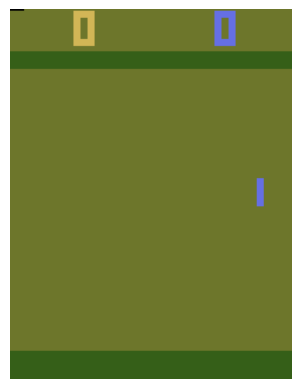

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym

env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array") 
env.reset()

a = env.action_space.sample()
s, r, terminated, truncated, info = env.step(a)
image = env.render() 

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off');

¿Cuáles son las dimensiones del estado?

In [11]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

Es decir una imagen a color de 210x160 con píxeles entre 0 y 255. Significaría una cantidad de filas en la tabla Q de:

$$
255^{210\cdot160\cdot3}
$$

## Aproximación de funciones

El espacio de estados del ejemplo anterior es imposible de mantener en una tabla Q. Cabe destacar que este espacio de estados está aun lejos de un problema del mundo real.

> Nos va a faltar memoría para guardar la tabla y datos para poder entrenar nuestro agente

¿Qué podemos hacer?

> Usar una representación más compacta para Q

En lugar de tener una tabla con todos las combinaciones estado/acción podemos aproximar **Q** usando un **modelo paramétrico**. Esta es la idea principal tras *Value function approximation* (VFA) y *Q function approximation*

El caso más sencillo es usar un **modelo lineal en sus parámetros**

$$
\begin{split}
\hat Q_\theta(s,a) &= \theta_0 \phi_0(s, a) + \theta_1 \phi_1(s, a) + \theta_2 \phi_2(s, a) + \ldots + \theta_M \phi_M (s,a) \\
&= \sum_{j=0}^M \theta_j \phi_j (s,a) 
\end{split}
$$

donde:

- $\{ \theta\}$ es un vector de parámetros con $M+1$ componentes
- $\{\phi\}$ es un conjunto de funciones base, *e.g.* polinomios, Fourier, árbol de decisión, kernels

En lugar de aprender $Q$ explicitamente el objetivo es aprender $\theta$.

:::{important}

La cantidad de parámetros es ahora independiente de la dimensionalidad del estado

:::

Al igual que antes nuestro objetivo es acercanos a la solución de la Ecuación de Bellman. Podemos escribir esto como el siguiente problema de optimización

$$
\min_\theta \| R(s,a) + \gamma \max_{a' \in \mathcal{A}} \hat Q_\theta( s',a') - \hat Q_\theta(s,a)\|^2
$$

de donde podemos aprender $\theta$ iterativamente usando usando gradiente descendente 

$$
\theta_j \leftarrow \theta_j + 2 \alpha \left(R(s,a) + \gamma \max_{a' \in \mathcal{A}} \hat Q_\theta (s',a') - \hat Q_\theta(s,a) \right) \phi_j(s,a)
$$

Sin embargo, un modelo lineal podría ser muy limitado. A continuación veremos como usar redes profundas para aproximar la función Q

## Deep Q-Network (DQN) 

En [(Minh et al. 2013)](https://arxiv.org/abs/1312.5602) se usaron redes neuronales profundas de tipo convolucional para resolver una serie de juegos de ATARI con Aprendizaje Reforzardo obteniendo [desempeño sobre-humano en muchos de las pruebas](https://deepmind.com/blog/article/deep-reinforcement-learning). El modelo, llamado *Deep Q-network*, utiliza como estado el valor de todos los píxeles de cuatro cuadros consecutivos.

La idea clave es

> Aprovechar la capacidad de las redes neuronales profundas para representar datos complejos, e.g. imágenes 

o más en concreto

> Aproximar la función Q usando una red convolucional entrenada directamente sobre los píxeles

Veremos primero una formulación general y luego su aplicación al caso de imágenes.

**Modelo**

- La entrada de la red es el estado $s$. El vector de estado puede tener valores continuos o discretos
- La salida de la red neuronal son los valores $Q(s, a_1), Q(s, a_2), \ldots, Q(s, a_N)$
    - Se considera un espacio de acciones discreto
    - Esto es más eficiente que considerar $a'$ como una entrada y retornar $Q(s, a')$
- La cantidad y tipo de las capas intermedias es decisión del usuario
    - Si tenemos datos continuos (atributos) usamos capas completamente conectadas
    - Si usamos píxeles es natural usar capas convolucionales
- La función de perdida que se ocupa en DQN es el error cuadrático medio entre la ecuación de Bellman y la predicción de la red

$$
\mathcal{L}(\theta) = \mathbb{E}\left[\left \| R(s,a) + \gamma \max_{a' \in \mathcal{A}} Q_\theta(s', a') - Q_\theta(s, a)\right \|^2\right]
$$

Recordemos: $s'$ es el estado al que llegamos luego de ejecutar $a$ sobre $s$

### Experience Replay y Memory replay

El entrenamiento usando sólo una instancia es bastante ruidoso (y un poco lento). Se debe considerar también que estamos entrenando con muestras muy correlacionadas (no iid) y esto puede introducir sesgos el entrenamiento de una red neuronal.

> Para entrenar la DQN adecuadamente  (Minh et al 2013) propone un astuto "truco" llamado *Experience replay*  

Esto consiste en almacenar la historia del agente en una memoria llamada *replay memory*

> Cada elemento en la memoria es una tupla $(s_t, a_t, r_{t+1}, s_{t+1})$

Con esto se crean mini-batches en orden aleatorio para entrenar.


### *Double DQN*

En [(van Hasselt, Guer y Silver, 2015)](https://arxiv.org/pdf/1509.06461.pdf) los autores notaron un problema importante en DQN. 

> Cuando calculamos $Q(s, a)$ y $\max Q(s', a')$ usando la misma red es muy posible que sobre-estimemos la calidad de nuestro objetivo. Adicionalmente si el objetivo cambia constantemente el entrenamiento será inestable

La solución propuesta consiste en usar redes neuronales distintas para la escoger la acción y para calcular el objetivo (ecuación de Bellman)

$$
\mathcal{L}(\theta, \phi) = \mathbb{E}\left[\left \| R(s,a) + \gamma Q_\phi\left(s', \text{arg}\max_{a' \in \mathcal{A}} Q_\theta(s', a')\right) - Q_\theta(s, a)\right\|^2\right]
$$

Se utiliza

- $Q_\theta$ con parámetros $\theta$ para escoger la acción: *policy network*
- $Q_\phi$ con parámetros $\phi$ para construir el objetivo: *target network*

Ambas redes comparten arquitectura y cantidad de neuronas, sin embargo sólo se optimiza la *policy network*

Después de un "cierto número de épocas" los parametros de la policy network "se copian" en la *target network*. ¿Cada cuantas épocas actualizo la *target network*? Otro hiper-parámetro para el algoritmo.

## Double-DQN en ambiente con estado continuo

Utilizaremos al ambiente [*LunarLander*](https://gymnasium.farama.org/environments/box2d/lunar_lander/), donde el objetivo es aterrizar el módulo lunar entre las banderas amarillas. El espacio de acciones es discreto: 

- 0: No actuar
- 1: Activar cohete izquierdo
- 2: Activar cohete principal
- 3: Activar cohete derecho

El espacio de estados es un vector de 8 dimensiones:

- Posición del módulo 
- Velocidad del módulo
- Ángulo y velocidad angular del módulo
- Booleanos que indican si las patas izquierda y derecha tocaron el suelo, respectivamente

El episodio termina si el módulo se estrella o aluniza fuera de las banderas. La recompensa aumenta a medida que el módulo se acerca a la plataforma. La recompensa disminuye con el ángulo y con cada vez que dispara los cohetes.

A continuación se muestre un agente con política aleatoria.

In [3]:
env = gym.make("LunarLander-v2", render_mode="human")

obs, _ = env.reset()
terminated, truncated = False, False
while True:
    
    action = env.action_space.sample()
    obs, rewards, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break
        
env.close()

Vamos a entrenar una Double Deep Q Network para resolver este problema utilizando la implementación de la librería `stable_baselines3`

    pip install stable-baselines3[extra]

La clase [DQN](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html), recibe:

- Un string indicando el tipo de modelo que implementará la policy, por ejemplo "MlpPolicy" para un modelo de dos capas completamente conectadas o "ConvPolicy" para un modelo convolucional
- El ambiente
- Los hiperparámetros del entrenamiento, entre ellos el factor de descuento (`gamma`), la tasa de aprendizaje, el tamaño del replay memory (`buffer_size`), el tamaño de batch, el trade-off entre explotación y exploración (epsilon-greedy) y la frecuencia de actualización del modelo *target* (`target_update_interval`).

El método tiene una función `learn` que realiza el entrenamiento. Podemos visualizar las curvas la *loss*, recompensa y largo de episodio utilizando tensorboard:

    tensorboard --logdir=/tmp/tensorboard/
    
Y luego abriendo: http://localhost:6006/

In [6]:
%%time

import torch
from stable_baselines3 import DQN

np.random.seed(1234)
torch.manual_seed(1234)

env = gym.make("LunarLander-v2")
env.reset()
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="/tmp/tensorboard/dqn_lunar_lander/",
            gamma=0.99, learning_rate=5e-4, batch_size=128, buffer_size=50_000, 
            target_update_interval=250, train_freq=4, gradient_steps=-1,
            learning_starts=0, exploration_fraction=0.12, exploration_final_eps=0.1, 
            policy_kwargs={'net_arch': [256, 256]})

model.learn(total_timesteps=10_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /tmp/tensorboard/dqn_lunar_lander/DQN_3
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -203     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 117      |
|    time_elapsed     | 3        |
|    total_timesteps  | 448      |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.616    |
|    n_updates        | 444      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 252      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 8        |
|    fps              | 108      |
|    time_elapsed     | 18       |
|    total_time

Agente entrenado en acción (se abrirá en una ventana)

In [12]:
env = gym.make("LunarLander-v2", render_mode="human")

obs, _ = env.reset()
terminated, truncated = False, False
while True:
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break
env.close()

**Comentarios**


¿Por qué a veces la *loss* sube? 

Recordemos que el "training set" está cambiando con cada paso. Es normal ver que los *loss* tenga subidas abruptas. En cierto modo estas subidas son deseables pues significa que nuestro algoritmo está "sorprendiendose" con nuevos estados

¿Qué significa si la recompensa promedio se fue en picada?

Lo que está ocurriendo es un problema común en deep RL que se llama: **"olvido catastrófico"**. El modelo es cada vez más bueno resolviendo el problema y la memoria se llena de "buenas transiciones". Por lo tanto los *minibatches* ya no tienen ejemplos erroneos y el modelo ya no sabe lo que está mal.

Se puede combatir con *prioritized replay memory* o con otros heurísticas:

- Reservar un espacio en la memoria para las transiciones (de exploración) iniciales 
- **Early stopping:** Guardar el modelo de mayor recompensa y detener el aprendizaje si la recompensa no sube en un cierto número de episodios

## [Rainbow DQN](https://arxiv.org/pdf/1710.02298.pdf)

Rainbow DQN es un trabajo que reune todos los avances relacionados a DQN

1. *Double DQN*: Usar un modelo separado para calcular los targets
1. *Replay memory*: Almacenar experiencias pasadas y muestrear aleatoriamente de la memoria para disminuir la correlación 
1. [*Prioritized experience replay*](https://arxiv.org/abs/1511.05952): El minibatch se construye ponderando las experiencias anteriores en función del error. Experiencias con más error tienen más probabilidad de ser escogidas. "Se puede aprender más de los ejemplos más difíciles"
1. [*Dueling networks*](https://arxiv.org/abs/1511.06581): Se separa la función $Q(s,a) = V(s) + A(s,a)$, donde cada función es una red neuronal que comparten capas. Con esto se puede aprender el valor de cada estado de forma desacoplada a la importancia relativa de las acciones
1. [*Noisy nets*](https://arxiv.org/abs/1706.10295): Capas de redes neuronales que incluyen un ruido paramétrico en sus parámetros lo que permite explorar sin necesidad de la heurística $\epsilon$-greddy
1. entre otros